<a href="https://colab.research.google.com/github/zahraDehghanian97/pneumonia_dignosis/blob/master/pneumonia_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**



<img src="https://www.pulmonologyadvisor.com/wp-content/uploads/sites/21/2020/01/respiratory.pathogens_G_1059134060.jpg" width="820" height="360" align="center"/>

## Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

<img src="https://www.ecanadanow.com/wp-content/uploads/2015/08/download-1000x600.jpg" width="820" height="360" align="center"/>

----------------------------------------------------
## Import libraries

In [ ]:
import pandas as pd       
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import cv2

import warnings
warnings.filterwarnings('ignore')

import random
import os
import glob
from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from tensorflow.random import set_seed
set_seed(42)

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

------------------------------
## Read Data

In [ ]:
main_path = "../input/chest-xray-pneumonia/chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]



test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

In [ ]:
df_train

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/train...
1,Normal,../input/chest-xray-pneumonia/chest_xray/train...
2,Normal,../input/chest-xray-pneumonia/chest_xray/train...
3,Normal,../input/chest-xray-pneumonia/chest_xray/train...
4,Normal,../input/chest-xray-pneumonia/chest_xray/train...
...,...,...
5211,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5212,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5213,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...
5214,Pneumonia,../input/chest-xray-pneumonia/chest_xray/train...


In [ ]:
df_test

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
1,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
2,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
3,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
4,Normal,../input/chest-xray-pneumonia/chest_xray/test/...
...,...,...
619,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
620,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
621,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...
622,Pneumonia,../input/chest-xray-pneumonia/chest_xray/test/...


In [ ]:
df_val

,class,image
0,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
1,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
2,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
3,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
4,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
5,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
6,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
7,Normal,../input/chest-xray-pneumonia/chest_xray/val/N...
8,Pneumonia,../input/chest-xray-pneumonia/chest_xray/val/P...
9,Pneumonia,../input/chest-xray-pneumonia/chest_xray/val/P...


----------------------------------------
## EDA

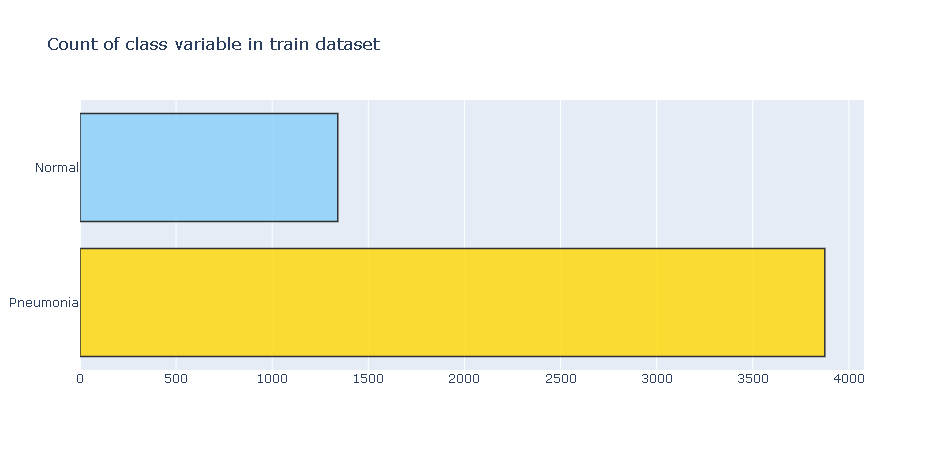

In [ ]:
Pneumonia = df_train[(df_train['class'] == 'Pneumonia')]
Normal = df_train[(df_train['class'] == 'Normal')]

trace = go.Bar(x = (len(Pneumonia), len(Normal)), y = ['Pneumonia', 'Normal'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of class variable in train dataset')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

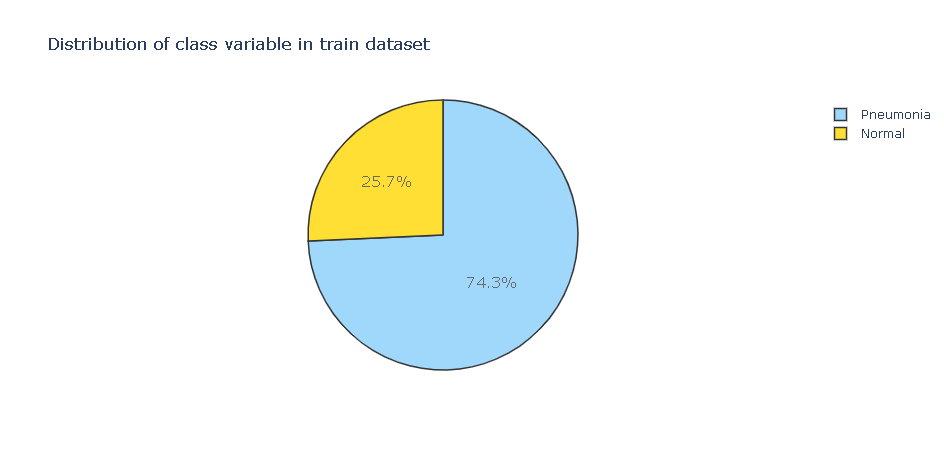

In [ ]:
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_train['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in train dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

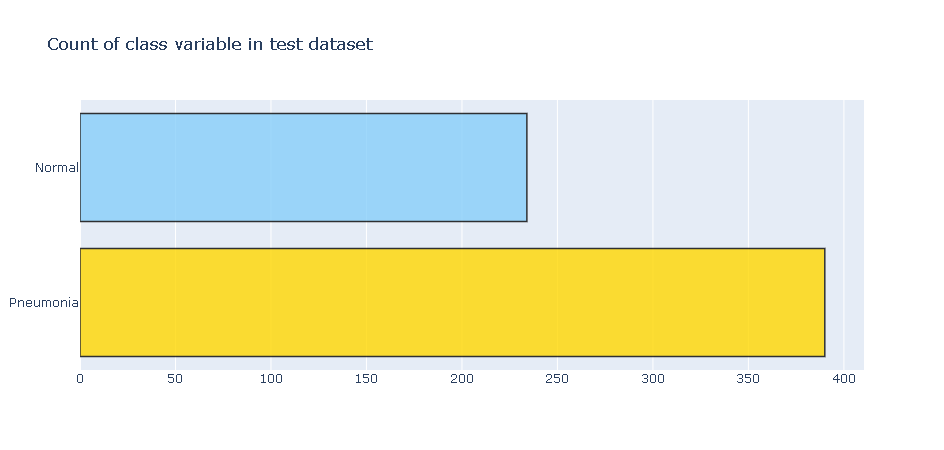

In [ ]:
Pneumonia = df_test[(df_test['class'] == 'Pneumonia')]
Normal = df_test[(df_test['class'] == 'Normal')]

trace = go.Bar(x = (len(Pneumonia), len(Normal)), y = ['Pneumonia', 'Normal'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of class variable in test dataset')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

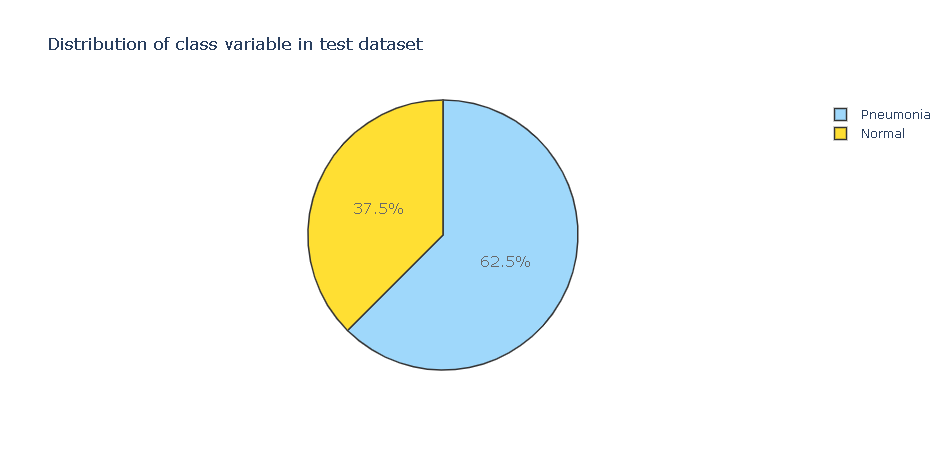

In [ ]:
trace = go.Pie(labels = ['Pneumonia', 'Normal'], values = df_test['class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of class variable in test dataset')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

The data seems imbalanced . To increase the no. of training examples


-----------------------------
## Previewing the images

Train Set - Normal


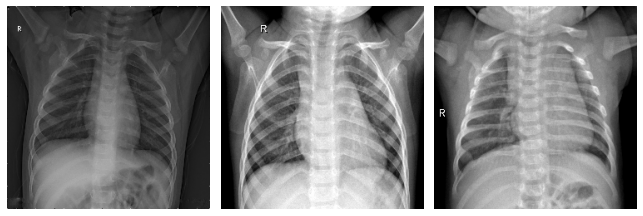

Train Set - Pneumonia


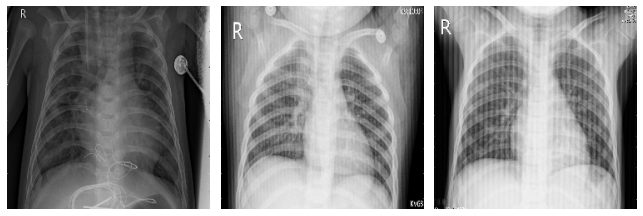

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 3):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (244,244))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

----------------------------------------
## Data Splitting

In [ ]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

------------------------
## Data Augmentation

In [ ]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


----------------
## Setting callbakcs

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

----------------------------
## Create Model

In [ ]:
def get_model():
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640  

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 121s 926ms/step - loss: 0.5344 - binary_accuracy: 0.7541 - val_loss: 0.6266 - val_binary_accuracy: 0.7433
Epoch 2/50
130/130 [==============================] - 100s 764ms/step - loss: 0.3446 - binary_accuracy: 0.8468 - val_loss: 1.2509 - val_binary_accuracy: 0.7433
Epoch 3/50
130/130 [==============================] - 112s 857ms/step - loss: 0.2715 - binary_accuracy: 0.8895 - val_loss: 1.3821 - val_binary_accuracy: 0.7433

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
Epoch 4/50
130/130 [==============================] - 98s 750ms/step - loss: 0.2375 - binary_accuracy: 0.9022 - val_loss: 1.1220 - val_binary_accuracy: 0.7433
Epoch 5/50
130/130 [==============================] - 103s 787ms/step - loss: 0.2222 - binary_accuracy: 0.9144 - val_loss: 0.3901 - val_binary_accuracy: 0.8075
Epoch 6/50
130/130 [==============================] - 100s 769ms/step - loss: 0.2165 - binary_accuracy: 0.9185 - val_lo

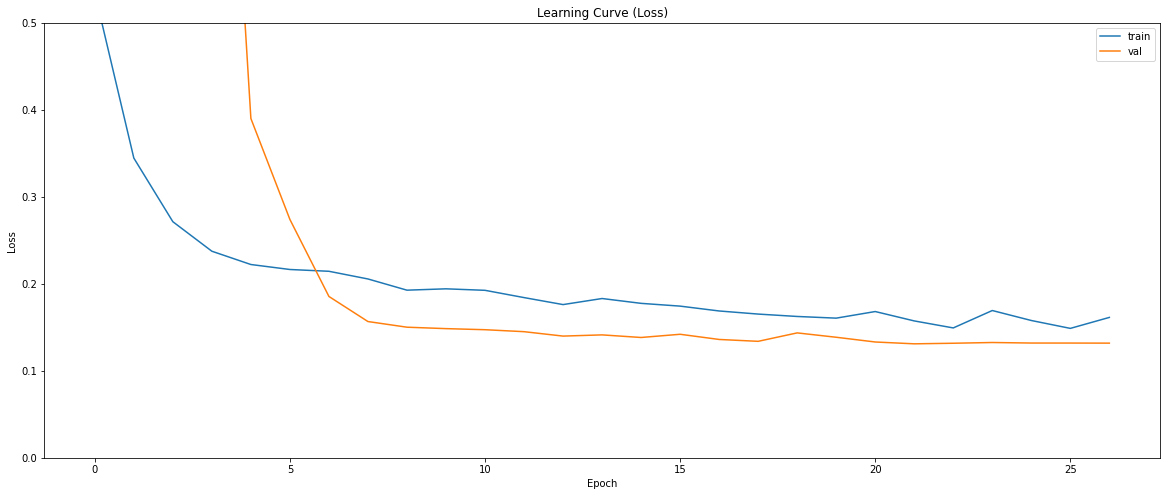

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

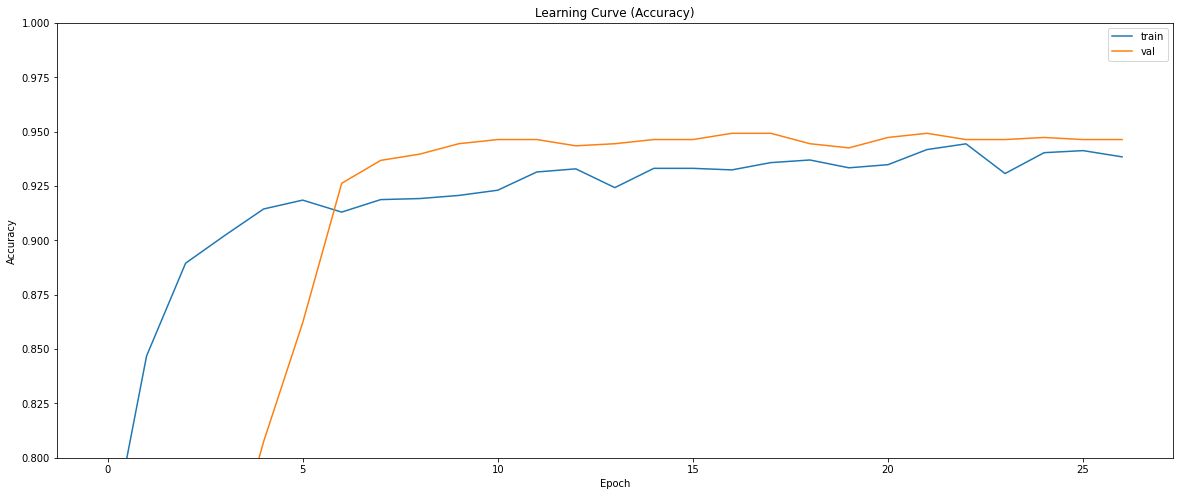

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.13104258477687836
Val accuracy: 0.9492337107658386


In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6089237928390503
Test accuracy: 0.7980769276618958


----------------------------
## ResNet

In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

234561536/234545216 [==============================] - 1s 0us/step


In [ ]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 58,594,049
Trainable params: 262,401
Non-trainable params: 58,331,648
___________________________________________

In [ ]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 116s 826ms/step - loss: 0.4334 - binary_accuracy: 0.8025 - val_loss: 0.2386 - val_binary_accuracy: 0.9138
Epoch 2/50
130/130 [==============================] - 103s 793ms/step - loss: 0.2122 - binary_accuracy: 0.9178 - val_loss: 0.1806 - val_binary_accuracy: 0.9330
Epoch 3/50
130/130 [==============================] - 110s 842ms/step - loss: 0.1819 - binary_accuracy: 0.9293 - val_loss: 0.1558 - val_binary_accuracy: 0.9416
Epoch 4/50
130/130 [==============================] - 112s 860ms/step - loss: 0.1547 - binary_accuracy: 0.9446 - val_loss: 0.1404 - val_binary_accuracy: 0.9511
Epoch 5/50
130/130 [==============================] - 117s 901ms/step - loss: 0.1429 - binary_accuracy: 0.9509 - val_loss: 0.1250 - val_binary_accuracy: 0.9540
Epoch 6/50
130/130 [==============================] - 103s 791ms/step - loss: 0.1346 - binary_accuracy: 0.9521 - val_loss: 0.1186 - val_binary_accuracy: 0.9569
Epoch 7/50
130/130 [====================

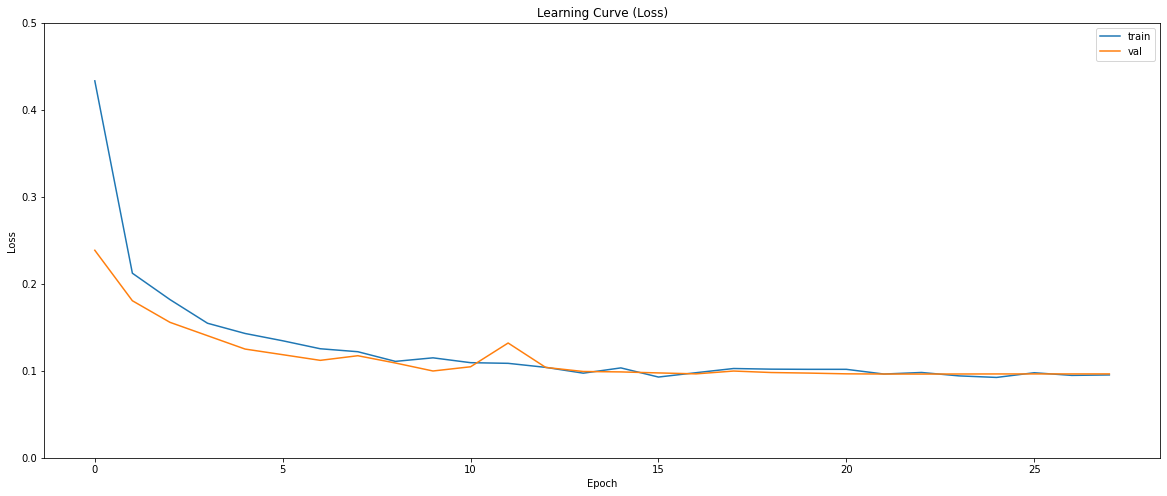

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

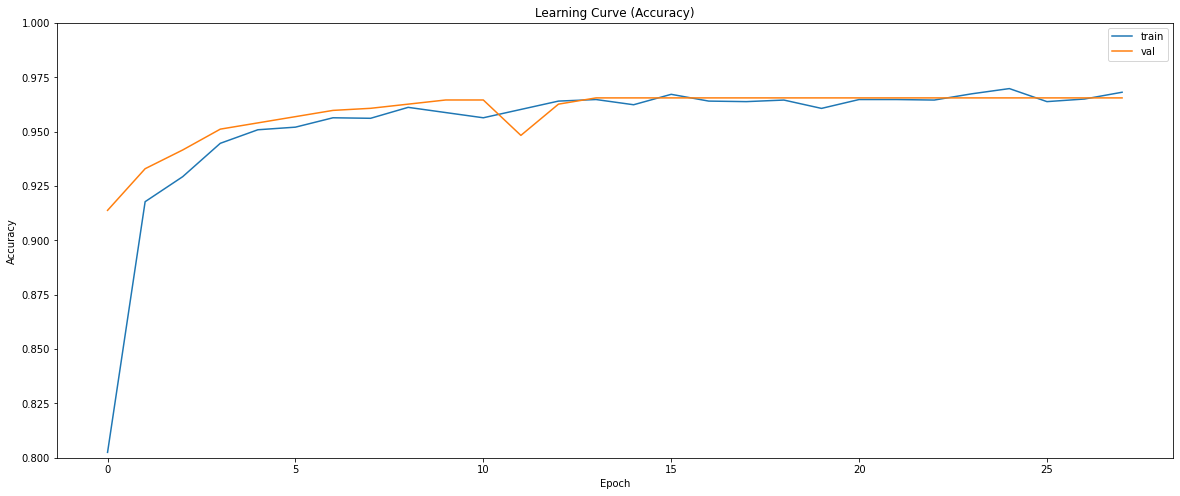

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09628243744373322
Val accuracy: 0.9655172228813171


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4116911292076111
Test accuracy: 0.8477563858032227


-------------------------
## Fine Tuning

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
130/130 [==============================] - 104s 800ms/step - loss: 0.0943 - binary_accuracy: 0.9676 - val_loss: 0.0963 - val_binary_accuracy: 0.9655
Epoch 2/50
130/130 [==============================] - 103s 790ms/step - loss: 0.0942 - binary_accuracy: 0.9674 - val_loss: 0.0963 - val_binary_accuracy: 0.9655
Epoch 3/50
130/130 [==============================] - 102s 785ms/step - loss: 0.0977 - binary_accuracy: 0.9650 - val_loss: 0.0963 - val_binary_accuracy: 0.9655

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.399999641359955e-10.
Epoch 4/50
130/130 [==============================] - 102s 781ms/step - loss: 0.1024 - binary_accuracy: 0.9636 - val_loss: 0.0963 - val_binary_accuracy: 0.9655
Epoch 5/50
130/130 [==============================] - 114s 877ms/step - loss: 0.0956 - binary_accuracy: 0.9686 - val_loss: 0.0963 - val_binary_accuracy: 0.9655

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.27999988386307e-10.
Epoch 6/50
130/130 [===================

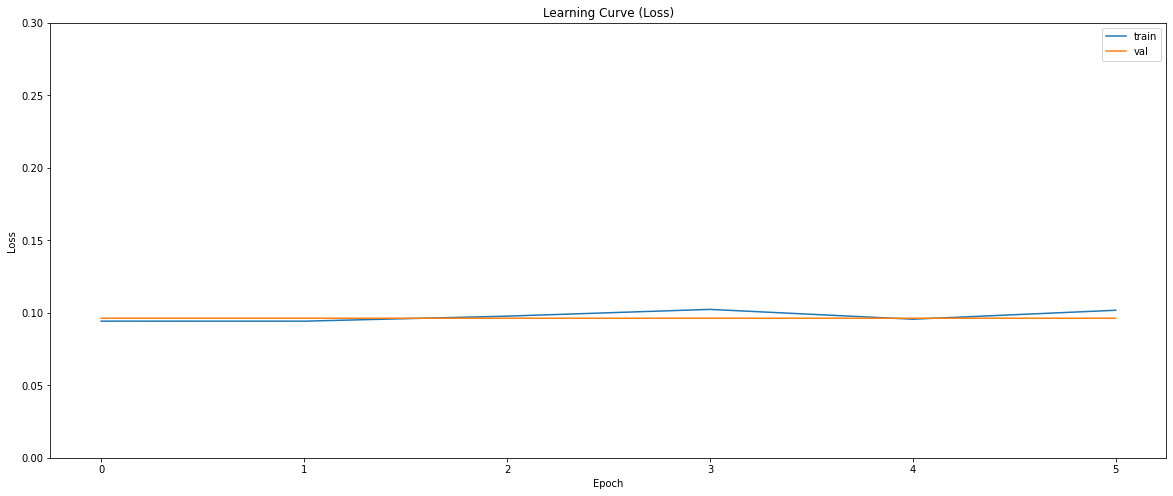

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

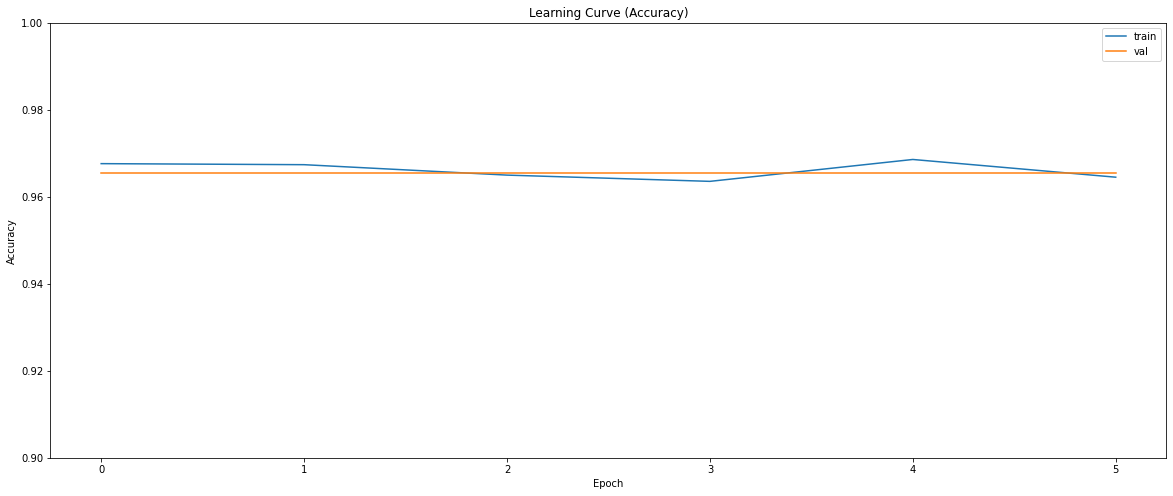

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.0962836742401123
Val accuracy: 0.9655172228813171


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4116835594177246
Test accuracy: 0.8477563858032227


----------------------------
## Evaluation

In [ ]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [ ]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8477564102564102


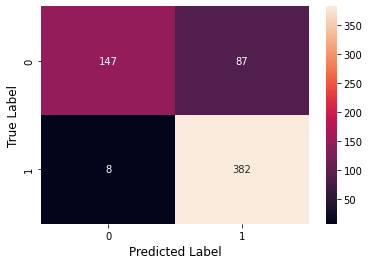

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(classification_report(Y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.63      0.76       234
   Normal (Class 1)       0.81      0.98      0.89       390

           accuracy                           0.85       624
          macro avg       0.88      0.80      0.82       624
       weighted avg       0.86      0.85      0.84       624



----------------------------
## Thank You 